**CSI5139 Assignment 1: Image Labelling - Linear Classiﬁcation**

In this assignment we use the CMU Image dataset, and train binary and multiclass linear classifier.

### Setup

In [133]:
import pgm2pil
import PIL.Image
import numpy as np
import os
from scipy import misc
from pprint import pprint
import imageio
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

origImageOpen = PIL.Image.open
PIL.Image.open = pgm2pil.imageOpenWrapper

In [88]:
# to make this notebook's output stable across runs
np.random.seed(42)

### CMU Image dataset

In [49]:
def appendArray(images, labels, image, label):
    label = np.array([label])
    image = image.reshape(1, -1)
    if images is None:
        images = image
        labels = label
    else:
        images = np.r_[images, image]
        labels = np.r_[labels, label]
    
    return [images, labels]

In [57]:
folder = 'datasets/faces/'
folders = [x[0] for x in os.walk(folder)]
folders = folders[1:]

A1, A2, A4 = None, None, None
Y1, Y2, Y4 = None, None, None
for fld in folders:
    for file in os.listdir(fld):
        labels = file
        file = os.path.join(fld, file)
        
        # handle .bad files
        if file.endswith('.pgm'):

            image = PIL.Image.open(file)
            image = np.array(image)
            
            # get target person, head pose, facial expression, sunglasses state
            labels = labels.split('.')
            labels = labels[0].split('_')

            # sort resolution
            if len(labels) == 4:
                A1, Y1 = appendArray(A1, Y1, image, labels)
            elif len(labels) == 5:
                res = labels[-1]
                labels = labels[:-1]
                if res == '2':
                    A2, Y2 = appendArray(A2, Y2, image, labels)
                elif res == '4':
                    A4, Y4 = appendArray(A4, Y4, image, labels)     

pprint(A1)
pprint(Y1)
print("# A1: ", len(A1))
print("# A1[0]: ", len(A1[0]))
print("# Y1: ", len(Y1))
print("# A2: ", len(A2))
print("# A2[0]: ", len(A2[0]))
print("# Y2: ", len(Y2))
print("# A4: ", len(A4))
print("# A4[0]: ", len(A4[0]))
print("# Y4", len(Y4))

array([[34.326923 ,  3.2692308,  1.6346154, ..., 80.09615  , 40.865383 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  3.227848 ,  0.       ,
         0.       ],
       [34.326923 ,  3.2692308,  0.       , ...,  6.5384617,  1.6346154,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  7.0833335, ..., 69.0625   , 69.0625   ,
        67.291664 ],
       [ 0.       ,  0.       ,  7.2340426, ..., 68.723404 , 66.914894 ,
        65.106384 ],
       [ 0.       ,  0.       ,  8.916084 , ..., 71.328674 , 69.545456 ,
        67.76224  ]], dtype=float32)
array([['an2i', 'left', 'angry', 'open'],
       ['an2i', 'left', 'angry', 'sunglasses'],
       ['an2i', 'left', 'happy', 'open'],
       ...,
       ['tammo', 'up', 'neutral', 'sunglasses'],
       ['tammo', 'up', 'sad', 'open'],
       ['tammo', 'up', 'sad', 'sunglasses']], dtype='<U10')
# A1:  624
# A1[0]:  15360
# Y1:  624
# A2:  624
# A2[0]:  3840
# Y2:  624
# A4:  624
# A4[0]:  960
# Y4 624


We can use the matplotlib library to plot the image as a grayscale image with pyplot. Let's find images labeled sunglasses.   

There are 311 images that are labeled sunglasses


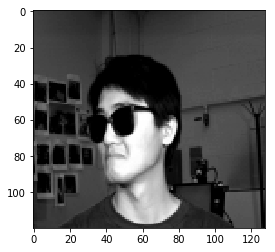

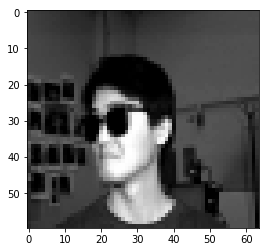

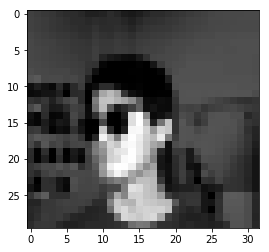

In [115]:
indexSung = np.where(Y1=='sunglasses')[0]
print('There are {0} images that are labeled sunglasses'.format(indexSung.shape[0]))

# randomly pick an image
np.random.seed(42)
pick = indexSung[np.random.choice(indexSung.shape[0])]
sung1, sung2, sung4 = A1[pick,:], A2[pick,:], A4[pick,:]
# reshape into a matrix
sung1_image, sung2_image, sung4_image = sung1.reshape(120, 128), sung2.reshape(60, 64), sung4.reshape(30, 32)
plt.ion() 
plt.imshow(sung1_image, cmap=plt.cm.gray)
plt.show()
plt.imshow(sung2_image, cmap=plt.cm.gray)
plt.show()
plt.imshow(sung4_image, cmap=plt.cm.gray)
plt.show()

### Test and Training Data

Split data into test and training data after re-shuffling the data. Split into 80/20 splits.

In [91]:
np.random.seed(42)
shuffle_index = np.random.permutation(624)
print(shuffle_index[0])
# reshuffle the data and use 500 samples as training and 124 as test
A1train, A1test, Y1train, Y1test = A1[shuffle_index[:500],:], A1[shuffle_index[500:],:], Y1[shuffle_index[:500]], Y1[shuffle_index[500:]]
A2train, A2test, Y2train, Y2test = A2[shuffle_index[:500],:], A2[shuffle_index[500:],:], Y2[shuffle_index[:500]], Y2[shuffle_index[500:]]
A4train, A4test, Y4train, Y4test = A4[shuffle_index[:500],:], A4[shuffle_index[500:],:], Y4[shuffle_index[:500]], Y4[shuffle_index[500:]]

446


### Binary Classifier
Use A4 to train a logistic regression classiﬁer for the class sunglasses vs. open. Find and print the confusion matrix, the accuracy, the recall and the precision of your classiﬁer based on the training data, as well as on the testing data. Print the ROC curve.

In [111]:
Y4train_sung = (Y4train == 'sunglasses')[:,3]
Y4test_sung = (Y4test == 'sunglasses')[:,3]
print('We have a training set with {0} images of sunglasses, and a test set with {1}'.format(sum(Y1train_sung),sum(Y1test_sung)))


We have a training set with 248 images of sunglasses, and a test set with 63


In [112]:
bin_clf = LogisticRegression(max_iter=5)
bin_clf.fit(A4train, Y4train_sung)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's pick a sunglasses out of the training set and see what our classifier predicts.

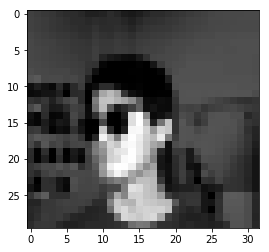

Classifier prediction is [ True] that the image is a sunglasses


In [120]:
indexSung = np.where(Y4=='sunglasses')[0]
# randomly pick an image
np.random.seed(42)
pick = indexSung[np.random.choice(indexSung.shape[0])]
sung4 = A4[pick,:]
# reshape into a matrix
sung4_image = sung4.reshape(30, 32)
plt.ion() 
plt.imshow(sung4_image, cmap=plt.cm.gray)
plt.show()

print('Classifier prediction is {0} that the image is a sunglasses'.format(bin_clf.predict([sung4])))

Let's calculate accuracy

In [127]:
Y4pred_train = bin_clf.predict(A4train)
print('Classifier accuracy on the training set is {0} '.format(accuracy_score(Y4train_sung, Y4pred_train)))

Y4pred_test = bin_clf.predict(A4test)
print('Classifier accuracy on the test set is {0} '.format(accuracy_score(Y4test_sung, Y4pred_test)))

Classifier accuracy on the training set is 1.0 
Classifier accuracy on the test set is 0.9193548387096774 


Let's calculate precision, recall and the f1 score; easy to crunch numbers ourselves but its built in. And the confusion matrix.

In [129]:
print('Classifier scores on training set: ')
print('Precision is {0} '.format(precision_score(Y4train_sung, Y4pred_train)))
print('Recall is {0} '.format(recall_score(Y4train_sung, Y4pred_train)))
print('F1 is {0} '.format(f1_score(Y4train_sung, Y4pred_train)))

print( 'And the confusion matrix: \n {0}'.format(confusion_matrix(Y4train_sung, Y4pred_train) ))

print()
print('Classifier scores on test set: ')
print('Precision is {0} '.format(precision_score(Y4test_sung, Y4pred_test)))
print('Recall is {0} '.format(recall_score(Y4test_sung, Y4pred_test)))
print('F1 is {0} '.format(f1_score(Y4test_sung, Y4pred_test)))

print( 'And the confusion matrix: \n {0}'.format(confusion_matrix(Y4test_sung, Y4pred_test) ))

Classifier scores on training set: 
Precision is 1.0 
Recall is 1.0 
F1 is 1.0 
And the confusion matrix: 
 [[252   0]
 [  0 248]]

Classifier scores on test set: 
Precision is 0.9491525423728814 
Recall is 0.8888888888888888 
F1 is 0.9180327868852458 
And the confusion matrix: 
 [[58  3]
 [ 7 56]]


Text(0,0.5,'Count')

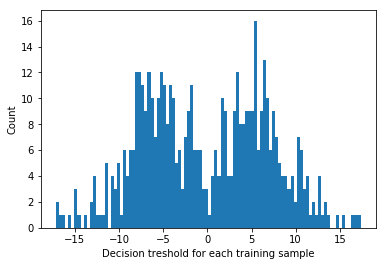

In [131]:
y_scores = cross_val_predict(bin_clf, A4train, Y4train_sung, cv=3,
                             method="decision_function")
n, bins, patches = plt.hist(y_scores, 100)

plt.xlabel('Decision treshold for each training sample')
plt.ylabel('Count')

In [132]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [134]:
fpr, tpr, thresholds = roc_curve(Y4train_sung, y_scores)

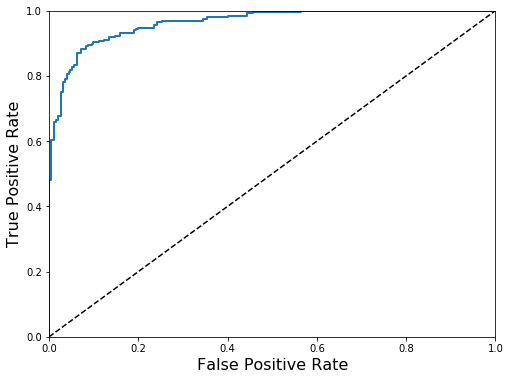

In [136]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()